In [1]:
import yfinance as yf
import datetime as dt
import pandas_datareader as pdr
import pandas as pd
import pandas_ta as pta
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, Conv2D, Flatten, MaxPooling1D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [2]:
import sys

pth_apple = "/Users/josesanchez/Desktop/Code/GitHub/StockPrediction/FileBase"
pth_win = "/Users/Usuario/Desktop/GitHub/StockPrediction/FileBase"
sys.path.append(pth_win)


from root_functions import add_indicators, up_down, full_prediction, full_prediction_binary, result, aprox_beneficios

## Descarga datos y creación dataset

In [3]:
sample_per = 10000
stock = 'EURGBP=X'

end = dt.date.today()- dt.timedelta(days=2)
start = end - dt.timedelta(days=(sample_per))
interval = '1d'

In [4]:
database = yf.download(stock, start=start, end=end, interval=interval)

[*********************100%***********************]  1 of 1 completed


In [5]:
#Añadimos indicadores

ema1=200
ema2=50
ema3=20

data_base = add_indicators(database)

#Añadimos columna up_down
data_base = up_down(data_base)

#Listado indicadores
data_base.columns

/Users/Usuario/Desktop/GitHub/StockPrediction/FileBase\root_functions.py:182: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe['CDL_UNIQUE3RIVER'] = cdl_pattern.iloc[:,59].values
/Users/Usuario/Desktop/GitHub/StockPrediction/FileBase\root_functions.py:183: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe['CDL_UPSIDEGAP2CROWS'] = cdl_pattern.iloc[:,60].values
/Users/Usuario/Desktop/GitHub/StockPrediction/FileBase\root_functions.py:184: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', '200ema',
       '50ema', '20ema', '14-high',
       ...
       'CDL_STICKSANDWICH', 'CDL_TAKURI', 'CDL_TASUKIGAP', 'CDL_THRUSTING',
       'CDL_TRISTAR', 'CDL_UNIQUE3RIVER', 'CDL_UPSIDEGAP2CROWS',
       'CDL_XSIDEGAP3METHODS', 'log_ret', 'Up_Down'],
      dtype='object', length=109)

In [6]:
#Hacemos un shift a la columna Up_Down para tener el signo de la tendencia de la siguiente vela
data_base['Up_Down'] = data_base['Up_Down'].shift(-1)

data_base.dropna(inplace=True)

In [7]:
#Filtramos las columnas que nos interesan para obtener el dataset de trabajo
db = data_base.copy()


data = db[['Up_Down','log_ret','Open', 'High', 'Low', 'Close', 'Adj Close','Volume', '200ema',
       '50ema', '20ema', '14-high', '14-low', '%K', '%D', 'RSI', 'MACD',
       'MACDh', 'MACDs', 'CCI', 'PSAR', 'BBl', 'BBm', 'BBu', 'BBb', 'BBp',
       'ATR', 'ADX', 'ADX_DMP', 'ADX_DMN', 'APO', 'AROON_D', 'AROON_U',
       'AROON_OSC', 'BOP', 'CMO', 'MOM', 'PPO', 'PPO_h', 'PPO_s', 'ROC',
       'STOCHRSI_k', 'STOCHRSI_d', 'TRIX', 'TRIX_s', 'WILLR', 'NATR',
       'CDL_2CROWS', 'CDL_3BLACKCROWS', 'CDL_3INSIDE', 'CDL_3LINESTRIKE',
       'CDL_3OUTSIDE', 'CDL_3STARSINSOUTH', 'CDL_3WHITESOLDIERS',
       'CDL_ABANDONEDBABY', 'CDL_ADVANCEBLOCK', 'CDL_BELTHOLD',
       'CDL_BREAKAWAY', 'CDL_CLOSINGMARUBOZU', 'CDL_CONCEALBABYSWALL',
       'CDL_COUNTERATTACK', 'CDL_DARKCLOUDCOVER', 'CDL_DOJI_10_0.1',
       'CDL_DOJISTAR', 'CDL_DRAGONFLYDOJI', 'CDL_ENGULFING',
       'CDL_EVENINGDOJISTAR', 'CDL_EVENINGSTAR', 'CDL_GAPSIDESIDEWHITE',
       'CDL_GRAVESTONEDOJI', 'CDL_HAMMER', 'CDL_HANGINGMAN', 'CDL_HARAMI',
       'CDL_HARAMICROSS', 'CDL_HIGHWAVE', 'CDL_HIKKAKE', 'CDL_HIKKAKEMOD',
       'CDL_HOMINGPIGEON', 'CDL_IDENTICAL3CROWS', 'CDL_INNECK',
       'CDL_INSIDE', 'CDL_INVERTEDHAMMER', 'CDL_KICKING',
       'CDL_KICKINGBYLENGTH', 'CDL_LADDERBOTTOM', 'CDL_LONGLEGGEDDOJI',
       'CDL_LONGLINE', 'CDL_MARUBOZU', 'CDL_MATCHINGLOW', 'CDL_MATHOLD',
       'CDL_MORNINGDOJISTAR', 'CDL_MORNINGSTAR', 'CDL_ONNECK',
       'CDL_PIERCING', 'CDL_RICKSHAWMAN', 'CDL_RISEFALL3METHODS',
       'CDL_SEPARATINGLINES', 'CDL_SHOOTINGSTAR', 'CDL_SHORTLINE',
       'CDL_SPINNINGTOP', 'CDL_STALLEDPATTERN', 'CDL_STICKSANDWICH',
       'CDL_TAKURI', 'CDL_TASUKIGAP', 'CDL_THRUSTING', 'CDL_TRISTAR',
       'CDL_UNIQUE3RIVER', 'CDL_UPSIDEGAP2CROWS', 'CDL_XSIDEGAP3METHODS']]


cols = data.columns

In [8]:
#Añadimos un filtro de outliers (por encima de 3 desviaciones quitamos el valor)

filt1 = np.abs(stats.zscore(data['log_ret'])) < 3
filt2 = np.abs(stats.zscore(data['log_ret'])) < 3

filt = (filt1 & filt2)

data = data[filt]

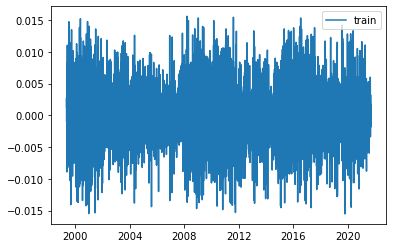

In [9]:
plt.plot(data['log_ret'], label='train')
plt.legend()
plt.show()

In [10]:
data.reset_index(inplace=True)
data.drop(columns=data.columns[0], inplace=True)

## Preparacion datos para el LSTM

In [11]:
#Convertimos todas las columnas a valor numerico
data = data.apply(pd.to_numeric)


#Escalamos los valores con un MinMaxScaler

data.dropna(inplace=True)

values = data.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

values = scaled

#Dividimos los datos entre train y test
train, val = train_test_split(values, test_size=0.2, shuffle=False)

#Dividimos datos validation entre validation y test
val, test = train_test_split(val, test_size=0.5, shuffle=False)

#Separamos los inputs de los outputs
train_X, train_y = train[:, 1:], train[:,0]
val_X, val_y = val[:, 1:], val[:,0]
test_X, test_y = test[:, 1:], test[:, 0]


#Generamos el reshape para poder incluir los valores en el modelo LSTM
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

(4580, 1, 108) (4580,) (573, 1, 108) (573,) (573, 1, 108) (573,)


## Creamos el modelo

In [12]:
#Generamos arquitectura del modelo
model = Sequential()

model.add(Dense(32, activation='LeakyReLU', kernel_initializer='he_uniform' ,input_shape=(train_X.shape[1], train_X.shape[2])))

model.add(LSTM(128, activation='LeakyReLU', return_sequences=True))
model.add(BatchNormalization())

model.add(LSTM(256, activation='LeakyReLU', return_sequences=True))
model.add(BatchNormalization())

model.add(LSTM(128, activation='LeakyReLU', return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.3))



model.add(Dense(32, activation='LeakyReLU'))



model.add(Dense(1, activation='sigmoid'))




In [13]:
epochs = 100
train_size = train_X.shape[0]
batch_size = 64

initial_learning_rate = 0.1
final_learning_rate = 0.000001
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = int(train_size/batch_size)

lr_schedule = ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

opt = SGD(learning_rate = lr_schedule )

In [14]:

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 32)             3488      
_________________________________________________________________
lstm (LSTM)                  (None, 1, 128)            82432     
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 128)            512       
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 256)            394240    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 256)            1024      
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 128)            197120    
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 128)            5

In [16]:
iterations=np.arange(1,500)

In [17]:
acierto = []
ben_total = []
ben_anual = []
loss = []
acc = []



for it in iterations:
    print(f'Iteration: {it}')
    #Entrenamos el modelo
    history = model.fit(train_X, train_y, epochs=epochs, batch_size = batch_size, validation_data=(val_X, val_y), verbose=0)
    # make a prediction
    yhat = model.predict(test_X)
    inv_y, inv_yhat = full_prediction(yhat, test_X, test_y)
    
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_y = scaler.inverse_transform(inv_y)

    inv_yhat_df = pd.DataFrame(data=inv_yhat, columns=cols)
    inv_y_df = pd.DataFrame(data=inv_y, columns=cols)
    
    res = result(inv_yhat, inv_y)

    res['Diff'] = np.where(res['Up_Down_yhat'] == res['Up_Down_y'] , 'Acierto', 'Error')

    res['Diff'].value_counts()

    per = res['Diff'].value_counts()['Acierto']/(res['Diff'].value_counts()['Acierto']+res['Diff'].value_counts()['Error'])
    
    
    score = model.evaluate(test_X, test_y, verbose=0)
    print(f'Test loss: {score[0]}')
    print(f'Test accuracy: {score[1]}')
    loss.append(score[0])
    acc.append(score[1])
    

    benef = aprox_beneficios(res, inv_yhat_df)
    
    benef_tot = benef[benef.size-1]-1
    benef_anual = benef_tot/(benef.size/253)
    print(f'Beneficios totales: {benef_tot}')
    print(f'Beneficios anuales: {benef_anual}')
    print(f'Acierto: {per} %')
    
    acierto.append(per)
    ben_total.append(benef_tot)
    ben_anual.append(benef_anual)
    print('---')

Iteration: 1
Test loss: 0.5767632126808167
Test accuracy: 0.7015706896781921
Beneficios totales: 0.9077414468486074
Beneficios anuales: 0.4008003246992979
Acierto: 0.7015706806282722 %
---
Iteration: 2
Test loss: 0.5767784714698792
Test accuracy: 0.69808030128479
Beneficios totales: 0.9002869312611985
Beneficios anuales: 0.39750888937012785
Acierto: 0.6980802792321117 %
---
Iteration: 3
Test loss: 0.5768044590950012
Test accuracy: 0.7015706896781921
Beneficios totales: 0.9077414468486074
Beneficios anuales: 0.4008003246992979
Acierto: 0.7015706806282722 %
---
Iteration: 4
Test loss: 0.5767130255699158
Test accuracy: 0.69808030128479
Beneficios totales: 0.9002869312611985
Beneficios anuales: 0.39750888937012785
Acierto: 0.6980802792321117 %
---
Iteration: 5
Test loss: 0.5766989588737488
Test accuracy: 0.7015706896781921
Beneficios totales: 0.9077414468486074
Beneficios anuales: 0.4008003246992979
Acierto: 0.7015706806282722 %
---
Iteration: 6
Test loss: 0.5766922235488892
Test accuracy:

Test loss: 0.5765039324760437
Test accuracy: 0.6998254656791687
Beneficios totales: 0.9404702411320143
Beneficios anuales: 0.41525125830087195
Acierto: 0.699825479930192 %
---
Iteration: 46
Test loss: 0.5768008828163147
Test accuracy: 0.6998254656791687
Beneficios totales: 0.9054410642408939
Beneficios anuales: 0.3997846234780911
Acierto: 0.699825479930192 %
---
Iteration: 47
Test loss: 0.5764656066894531
Test accuracy: 0.69808030128479
Beneficios totales: 0.9002869312611985
Beneficios anuales: 0.39750888937012785
Acierto: 0.6980802792321117 %
---
Iteration: 48
Test loss: 0.5767433643341064
Test accuracy: 0.7015706896781921
Beneficios totales: 0.945733362980302
Beneficios anuales: 0.4175751148935714
Acierto: 0.7015706806282722 %
---
Iteration: 49
Test loss: 0.5767152309417725
Test accuracy: 0.69808030128479
Beneficios totales: 0.9002869312611985
Beneficios anuales: 0.39750888937012785
Acierto: 0.6980802792321117 %
---
Iteration: 50
Test loss: 0.5768114924430847
Test accuracy: 0.6998254

Test loss: 0.5765228867530823
Test accuracy: 0.6998254656791687
Beneficios totales: 0.9054410642408939
Beneficios anuales: 0.3997846234780911
Acierto: 0.699825479930192 %
---
Iteration: 90
Test loss: 0.5768336653709412
Test accuracy: 0.69808030128479
Beneficios totales: 0.9002869312611985
Beneficios anuales: 0.39750888937012785
Acierto: 0.6980802792321117 %
---
Iteration: 91
Test loss: 0.5765520930290222
Test accuracy: 0.69808030128479
Beneficios totales: 0.9002869312611985
Beneficios anuales: 0.39750888937012785
Acierto: 0.6980802792321117 %
---
Iteration: 92
Test loss: 0.5769066214561462
Test accuracy: 0.6998254656791687
Beneficios totales: 0.8935730728468356
Beneficios anuales: 0.39454448068106357
Acierto: 0.699825479930192 %
---
Iteration: 93
Test loss: 0.5767425894737244
Test accuracy: 0.69808030128479
Beneficios totales: 0.9002869312611985
Beneficios anuales: 0.39750888937012785
Acierto: 0.6980802792321117 %
---
Iteration: 94
Test loss: 0.5771564841270447
Test accuracy: 0.7015706

Test loss: 0.5766516923904419
Test accuracy: 0.69808030128479
Beneficios totales: 0.9002869312611985
Beneficios anuales: 0.39750888937012785
Acierto: 0.6980802792321117 %
---
Iteration: 134
Test loss: 0.5771563649177551
Test accuracy: 0.7015706896781921
Beneficios totales: 0.9077414468486074
Beneficios anuales: 0.4008003246992979
Acierto: 0.7015706806282722 %
---
Iteration: 135
Test loss: 0.5766232013702393
Test accuracy: 0.6998254656791687
Beneficios totales: 0.9025810914366956
Beneficios anuales: 0.3985218431648936
Acierto: 0.699825479930192 %
---
Iteration: 136
Test loss: 0.5767543911933899
Test accuracy: 0.69808030128479
Beneficios totales: 0.9002869312611985
Beneficios anuales: 0.39750888937012785
Acierto: 0.6980802792321117 %
---
Iteration: 137
Test loss: 0.5766555070877075
Test accuracy: 0.69808030128479
Beneficios totales: 0.9002869312611985
Beneficios anuales: 0.39750888937012785
Acierto: 0.6980802792321117 %
---
Iteration: 138
Test loss: 0.5767624378204346
Test accuracy: 0.69

Test loss: 0.5766980648040771
Test accuracy: 0.7015706896781921
Beneficios totales: 0.9077414468486074
Beneficios anuales: 0.4008003246992979
Acierto: 0.7015706806282722 %
---
Iteration: 178
Test loss: 0.5767199397087097
Test accuracy: 0.6998254656791687
Beneficios totales: 0.9054410642408939
Beneficios anuales: 0.3997846234780911
Acierto: 0.699825479930192 %
---
Iteration: 179
Test loss: 0.5766833424568176
Test accuracy: 0.6963350772857666
Beneficios totales: 0.8754467748361829
Beneficios anuales: 0.38654107161178763
Acierto: 0.6963350785340314 %
---
Iteration: 180
Test loss: 0.5764941573143005
Test accuracy: 0.6998254656791687
Beneficios totales: 0.9054410642408939
Beneficios anuales: 0.3997846234780911
Acierto: 0.699825479930192 %
---
Iteration: 181
Test loss: 0.5765970349311829
Test accuracy: 0.69808030128479
Beneficios totales: 0.9002869312611985
Beneficios anuales: 0.39750888937012785
Acierto: 0.6980802792321117 %
---
Iteration: 182
Test loss: 0.5769843459129333
Test accuracy: 0.

Test loss: 0.5765385627746582
Test accuracy: 0.69808030128479
Beneficios totales: 0.9002869312611985
Beneficios anuales: 0.39750888937012785
Acierto: 0.6980802792321117 %
---
Iteration: 222
Test loss: 0.5766566395759583
Test accuracy: 0.6998254656791687
Beneficios totales: 0.9054410642408939
Beneficios anuales: 0.3997846234780911
Acierto: 0.699825479930192 %
---
Iteration: 223
Test loss: 0.5766916275024414
Test accuracy: 0.69808030128479
Beneficios totales: 0.8805335340591336
Beneficios anuales: 0.38878705779574313
Acierto: 0.6980802792321117 %
---
Iteration: 224
Test loss: 0.5767750144004822
Test accuracy: 0.6998254656791687
Beneficios totales: 0.9054410642408939
Beneficios anuales: 0.3997846234780911
Acierto: 0.699825479930192 %
---
Iteration: 225
Test loss: 0.5766089558601379
Test accuracy: 0.69808030128479
Beneficios totales: 0.9002869312611985
Beneficios anuales: 0.39750888937012785
Acierto: 0.6980802792321117 %
---
Iteration: 226
Test loss: 0.5768886804580688
Test accuracy: 0.701

Test loss: 0.5763077139854431
Test accuracy: 0.69808030128479
Beneficios totales: 0.9002869312611985
Beneficios anuales: 0.39750888937012785
Acierto: 0.6980802792321117 %
---
Iteration: 266
Test loss: 0.5766587257385254
Test accuracy: 0.7015706896781921
Beneficios totales: 0.9077414468486074
Beneficios anuales: 0.4008003246992979
Acierto: 0.7015706806282722 %
---
Iteration: 267
Test loss: 0.5767812132835388
Test accuracy: 0.69808030128479
Beneficios totales: 0.9002869312611985
Beneficios anuales: 0.39750888937012785
Acierto: 0.6980802792321117 %
---
Iteration: 268
Test loss: 0.5772284269332886
Test accuracy: 0.7015706896781921
Beneficios totales: 0.9077414468486074
Beneficios anuales: 0.4008003246992979
Acierto: 0.7015706806282722 %
---
Iteration: 269
Test loss: 0.576854944229126
Test accuracy: 0.7015706896781921
Beneficios totales: 0.9077414468486074
Beneficios anuales: 0.4008003246992979
Acierto: 0.7015706806282722 %
---
Iteration: 270
Test loss: 0.5768139362335205
Test accuracy: 0.6

Test loss: 0.5765082240104675
Test accuracy: 0.6998254656791687
Beneficios totales: 0.9025810914366956
Beneficios anuales: 0.3985218431648936
Acierto: 0.699825479930192 %
---
Iteration: 310
Test loss: 0.5767639875411987
Test accuracy: 0.6998254656791687
Beneficios totales: 0.9054410642408939
Beneficios anuales: 0.3997846234780911
Acierto: 0.699825479930192 %
---
Iteration: 311
Test loss: 0.5768548250198364
Test accuracy: 0.69808030128479
Beneficios totales: 0.9002869312611985
Beneficios anuales: 0.39750888937012785
Acierto: 0.6980802792321117 %
---
Iteration: 312
Test loss: 0.5768760442733765
Test accuracy: 0.69808030128479
Beneficios totales: 0.9002869312611985
Beneficios anuales: 0.39750888937012785
Acierto: 0.6980802792321117 %
---
Iteration: 313
Test loss: 0.576721727848053
Test accuracy: 0.7033158540725708
Beneficios totales: 0.9480823892878834
Beneficios anuales: 0.4186122940485768
Acierto: 0.7033158813263525 %
---
Iteration: 314
Test loss: 0.5770580768585205
Test accuracy: 0.698

Test loss: 0.5768185257911682
Test accuracy: 0.7015706896781921
Beneficios totales: 0.9077414468486074
Beneficios anuales: 0.4008003246992979
Acierto: 0.7015706806282722 %
---
Iteration: 354
Test loss: 0.5766572952270508
Test accuracy: 0.6998254656791687
Beneficios totales: 0.9054410642408939
Beneficios anuales: 0.3997846234780911
Acierto: 0.699825479930192 %
---
Iteration: 355
Test loss: 0.5767645239830017
Test accuracy: 0.69808030128479
Beneficios totales: 0.9002869312611985
Beneficios anuales: 0.39750888937012785
Acierto: 0.6980802792321117 %
---
Iteration: 356
Test loss: 0.5767603516578674
Test accuracy: 0.69808030128479
Beneficios totales: 0.9002869312611985
Beneficios anuales: 0.39750888937012785
Acierto: 0.6980802792321117 %
---
Iteration: 357
Test loss: 0.5768516063690186
Test accuracy: 0.7015706896781921
Beneficios totales: 0.945733362980302
Beneficios anuales: 0.4175751148935714
Acierto: 0.7015706806282722 %
---
Iteration: 358
Test loss: 0.5766423940658569
Test accuracy: 0.69

Test loss: 0.5765821933746338
Test accuracy: 0.6998254656791687
Beneficios totales: 0.9025810914366956
Beneficios anuales: 0.3985218431648936
Acierto: 0.699825479930192 %
---
Iteration: 398
Test loss: 0.5769546031951904
Test accuracy: 0.7015706896781921
Beneficios totales: 0.9077414468486074
Beneficios anuales: 0.4008003246992979
Acierto: 0.7015706806282722 %
---
Iteration: 399
Test loss: 0.5772969722747803
Test accuracy: 0.7033158540725708
Beneficios totales: 0.9480823892878834
Beneficios anuales: 0.4186122940485768
Acierto: 0.7033158813263525 %
---
Iteration: 400
Test loss: 0.5762240290641785
Test accuracy: 0.6998254656791687
Beneficios totales: 0.9025810914366956
Beneficios anuales: 0.3985218431648936
Acierto: 0.699825479930192 %
---
Iteration: 401
Test loss: 0.5769922733306885
Test accuracy: 0.7033158540725708
Beneficios totales: 0.9480823892878834
Beneficios anuales: 0.4186122940485768
Acierto: 0.7033158813263525 %
---
Iteration: 402
Test loss: 0.5766526460647583
Test accuracy: 0.

Test loss: 0.5768705010414124
Test accuracy: 0.6998254656791687
Beneficios totales: 0.9054410642408939
Beneficios anuales: 0.3997846234780911
Acierto: 0.699825479930192 %
---
Iteration: 442
Test loss: 0.5769535303115845
Test accuracy: 0.6998254656791687
Beneficios totales: 0.9054410642408939
Beneficios anuales: 0.3997846234780911
Acierto: 0.699825479930192 %
---
Iteration: 443
Test loss: 0.5767470002174377
Test accuracy: 0.69808030128479
Beneficios totales: 0.9002869312611985
Beneficios anuales: 0.39750888937012785
Acierto: 0.6980802792321117 %
---
Iteration: 444
Test loss: 0.5765388607978821
Test accuracy: 0.7015706896781921
Beneficios totales: 0.945733362980302
Beneficios anuales: 0.4175751148935714
Acierto: 0.7015706806282722 %
---
Iteration: 445
Test loss: 0.576751708984375
Test accuracy: 0.7015706896781921
Beneficios totales: 0.9077414468486074
Beneficios anuales: 0.4008003246992979
Acierto: 0.7015706806282722 %
---
Iteration: 446
Test loss: 0.576872706413269
Test accuracy: 0.6998

Test loss: 0.5767853260040283
Test accuracy: 0.6998254656791687
Beneficios totales: 0.9054410642408939
Beneficios anuales: 0.3997846234780911
Acierto: 0.699825479930192 %
---
Iteration: 486
Test loss: 0.576566755771637
Test accuracy: 0.69808030128479
Beneficios totales: 0.9002869312611985
Beneficios anuales: 0.39750888937012785
Acierto: 0.6980802792321117 %
---
Iteration: 487
Test loss: 0.5767364501953125
Test accuracy: 0.6998254656791687
Beneficios totales: 0.9054410642408939
Beneficios anuales: 0.3997846234780911
Acierto: 0.699825479930192 %
---
Iteration: 488
Test loss: 0.5767435431480408
Test accuracy: 0.6998254656791687
Beneficios totales: 0.9025810914366956
Beneficios anuales: 0.3985218431648936
Acierto: 0.699825479930192 %
---
Iteration: 489
Test loss: 0.5764328241348267
Test accuracy: 0.7015706896781921
Beneficios totales: 0.9077414468486074
Beneficios anuales: 0.4008003246992979
Acierto: 0.7015706806282722 %
---
Iteration: 490
Test loss: 0.5768388509750366
Test accuracy: 0.701

In [18]:
df_iterate = pd.DataFrame({'% acierto':acierto, 'Benef Total':ben_total, 'Benef Anual':ben_anual, 'Loss':loss, 'Accuracy':acc})

In [19]:
df_iterate.describe()

,% acierto,Benef Total,Benef Anual,Loss,Accuracy
count,499.000000,499.000000,499.000000,499.000000,499.000000
mean,0.700126,0.911586,0.402498,0.576753,0.700126
std,0.001701,0.017654,0.007795,0.000199,0.001701
min,0.696335,0.875447,0.386541,0.576224,0.696335
25%,0.698080,0.900287,0.397509,0.576617,0.698080
50%,0.699825,0.905441,0.399785,0.576751,0.699825
75%,0.701571,0.907741,0.400800,0.576878,0.701571
max,0.703316,0.948082,0.418612,0.577335,0.703316


In [21]:
df_iterate.to_csv('StockPrediction_Iteration.csv')